In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_curve, auc, confusion_matrix
from torch.utils.data import DataLoader, TensorDataset

In [2]:
# Check if GPU is available
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using GPU")
else:
    device = torch.device("cpu")
    print("Using CPU")

Using GPU


In [3]:
# Load the EEG features
df = pd.read_csv(r"C:\Users\Izwan\Desktop\alzheimer-prediction\code\1-feature-extraction\extracted-features-All_Subjects-DWT3-3s.csv")

In [4]:
# Sort the data by subject and epoch to maintain chronological order
df = df.sort_values(by=['subject', 'epoch'])

# Splitting the data chronologically
num_epochs_per_subject = df['epoch'].max()
train_split = int(num_epochs_per_subject * 0.7)  # 70% of the epochs for training
val_split = int(num_epochs_per_subject * 0.85)  # 15% for validation, remaining 15% for testing

In [5]:
# Initialize lists to store the splits
train_indices, val_indices, test_indices = [], [], []

# Split data for each subject
subjects = df['subject'].unique()
for subj in subjects:
    subj_df = df[df['subject'] == subj]
    
    # Append indices to the respective lists
    train_indices.extend(subj_df.iloc[:train_split].index)
    val_indices.extend(subj_df.iloc[train_split:val_split].index)
    test_indices.extend(subj_df.iloc[val_split:].index)

# Creating DataFrames for each split
train_df = df.loc[train_indices]
val_df = df.loc[val_indices]
test_df = df.loc[test_indices]

# Ensure proper encoding of target variable
X_train = train_df.drop(['epoch', 'subject', 'gender', 'class', 'mmse'], axis=1)
X_val = val_df.drop(['epoch', 'subject', 'gender', 'class', 'mmse'], axis=1)
X_test = test_df.drop(['epoch', 'subject', 'gender', 'class', 'mmse'], axis=1)

label_mapping = {'A': 0, 'C': 1, 'F': 2}
y_train = train_df['class'].map(label_mapping).values
y_val = val_df['class'].map(label_mapping).values
y_test = test_df['class'].map(label_mapping).values

In [6]:
# Check subject epochs in each set
print("Train Set Summary:")
print(train_df.groupby('subject')['epoch'].agg(['min', 'max', 'count']))

print("\nValidation Set Summary:")
print(val_df.groupby('subject')['epoch'].agg(['min', 'max', 'count']))

print("\nTest Set Summary:")
print(test_df.groupby('subject')['epoch'].agg(['min', 'max', 'count']))

Train Set Summary:
         min  max  count
subject                 
sub-001    1   71     71
sub-002    1   71     71
sub-003    1   71     71
sub-004    1   71     71
sub-005    1   71     71
...      ...  ...    ...
sub-084    1   71     71
sub-085    1   71     71
sub-086    1   71     71
sub-087    1   71     71
sub-088    1   71     71

[88 rows x 3 columns]

Validation Set Summary:
         min  max  count
subject                 
sub-001   72   86     15
sub-002   72   86     15
sub-003   72   86     15
sub-004   72   86     15
sub-005   72   86     15
...      ...  ...    ...
sub-084   72   86     15
sub-085   72   86     15
sub-086   72   86     15
sub-087   72   86     15
sub-088   72   86     15

[88 rows x 3 columns]

Test Set Summary:
         min  max  count
subject                 
sub-001   87  102     16
sub-002   87  102     16
sub-003   87  102     16
sub-004   87  102     16
sub-005   87  102     16
...      ...  ...    ...
sub-084   87  102     16
sub-085   87  10

In [7]:
# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Convert data to tensors
X_train = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1).to(device)
X_val = torch.tensor(X_val, dtype=torch.float32).unsqueeze(1).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).unsqueeze(1).to(device)
y_train = torch.tensor(y_train, dtype=torch.long).to(device)
y_val = torch.tensor(y_val, dtype=torch.long).to(device)
y_test = torch.tensor(y_test, dtype=torch.long).to(device)

# Create DataLoaders
batch_size = 64
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=batch_size, shuffle=False)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=batch_size, shuffle=False)

In [8]:
# Define the LSTM model for multi-class classification
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size_1, hidden_size_2, output_size):
        super(LSTMModel, self).__init__()
        self.lstm1 = nn.LSTM(input_size, hidden_size_1, batch_first=True)
        self.dropout1 = nn.Dropout(0.2)  # Dropout after the first LSTM layer
        self.lstm2 = nn.LSTM(hidden_size_1, hidden_size_2, batch_first=True)
        self.dropout = nn.Dropout(0.2)  # Dropout after the second LSTM layer
        self.fc = nn.Linear(hidden_size_2, output_size)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x, _ = self.lstm1(x)
        x = self.dropout1(x)  # Apply Dropout1
        x, _ = self.lstm2(x)
        x = self.dropout(x)  # Apply Dropout2
        x = x[:, -1, :]  # Use the last time step's output
        x = self.fc(x)
        x = self.softmax(x)  # Apply Softmax for probabilities
        return x

In [9]:
# Model, criterion, optimizer setup
input_size = X_train.shape[2]
hidden_size_1 = 64
hidden_size_2 = 8
output_size = 3  # Three classes: 'A', 'C', 'F'

model = LSTMModel(input_size, hidden_size_1, hidden_size_2, output_size).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

In [10]:
# Train the model
epochs = 100
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(epochs):
    # Training phase
    model.train()
    epoch_loss = 0
    correct_train = 0
    total_train = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        
        # Calculate training accuracy
        _, predicted = torch.max(outputs.data, 1)
        total_train += y_batch.size(0)
        correct_train += (predicted == y_batch).sum().item()
    
    train_losses.append(epoch_loss / len(train_loader))
    train_accuracy = 100 * correct_train / total_train
    train_accuracies.append(train_accuracy)

    # Validation phase
    model.eval()
    val_loss = 0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()
            
            # Calculate validation accuracy
            _, predicted = torch.max(outputs.data, 1)
            total_val += y_batch.size(0)
            correct_val += (predicted == y_batch).sum().item()
    
    val_losses.append(val_loss / len(val_loader))
    val_accuracy = 100 * correct_val / total_val
    val_accuracies.append(val_accuracy)
    
    print(f"Epoch {epoch+1}/{epochs}, Training Loss: {train_losses[-1]:.4f}, Validation Loss: {val_losses[-1]:.4f}, Training Accuracy: {train_accuracy:.2f}%, Validation Accuracy: {val_accuracy:.2f}%")

Epoch 1/100, Training Loss: 1.0712, Validation Loss: 1.0296, Training Accuracy: 46.57%, Validation Accuracy: 54.70%
Epoch 2/100, Training Loss: 0.9862, Validation Loss: 0.9594, Training Accuracy: 59.07%, Validation Accuracy: 60.00%
Epoch 3/100, Training Loss: 0.9251, Validation Loss: 0.8961, Training Accuracy: 64.69%, Validation Accuracy: 67.12%
Epoch 4/100, Training Loss: 0.8771, Validation Loss: 0.8601, Training Accuracy: 70.10%, Validation Accuracy: 70.61%
Epoch 5/100, Training Loss: 0.8392, Validation Loss: 0.8458, Training Accuracy: 73.67%, Validation Accuracy: 71.36%
Epoch 6/100, Training Loss: 0.8133, Validation Loss: 0.8156, Training Accuracy: 76.41%, Validation Accuracy: 74.39%
Epoch 7/100, Training Loss: 0.7914, Validation Loss: 0.8068, Training Accuracy: 78.39%, Validation Accuracy: 75.76%
Epoch 8/100, Training Loss: 0.7762, Validation Loss: 0.8013, Training Accuracy: 79.72%, Validation Accuracy: 75.53%
Epoch 9/100, Training Loss: 0.7613, Validation Loss: 0.7847, Training Ac

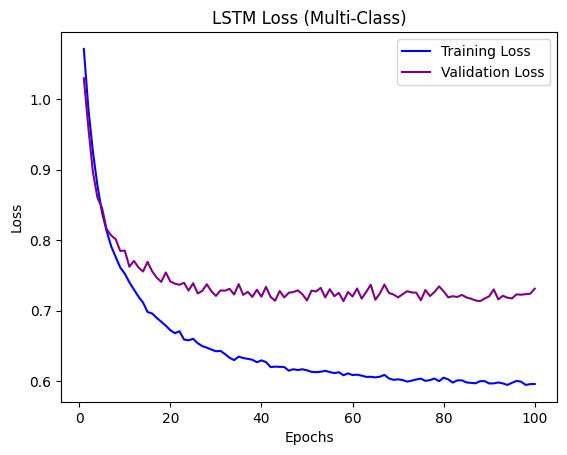

In [11]:
# Plotting the loss curve
plt.figure()
plt.plot(range(1, epochs + 1), train_losses, label='Training Loss', color='blue')
plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss', color='purple')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('LSTM Loss (Multi-Class)')
plt.legend()
plt.show()

In [12]:
# Evaluate the model
model.eval()
y_pred_prob, y_pred = [], []
with torch.no_grad():
    for X_batch, _ in test_loader:
        outputs = model(X_batch).squeeze()
        y_pred_prob.extend(outputs.tolist())  # Collect probabilities for all classes
        y_pred.extend(torch.argmax(outputs, dim=1).tolist())  # Collect predicted classes

# Convert predictions and true labels to CPU for metric calculation
y_test_cpu = y_test.cpu()
y_pred_cpu = torch.tensor(y_pred).cpu()

# Generate and print the classification report
target_names = ['Alzheimer', 'Healthy', 'FTD']
print("Classification Report:")
print(classification_report(y_test_cpu, y_pred_cpu, target_names=target_names))

Classification Report:
              precision    recall  f1-score   support

   Alzheimer       0.79      0.80      0.80       576
     Healthy       0.77      0.85      0.81       464
         FTD       0.80      0.68      0.73       368

    accuracy                           0.79      1408
   macro avg       0.79      0.78      0.78      1408
weighted avg       0.79      0.79      0.79      1408



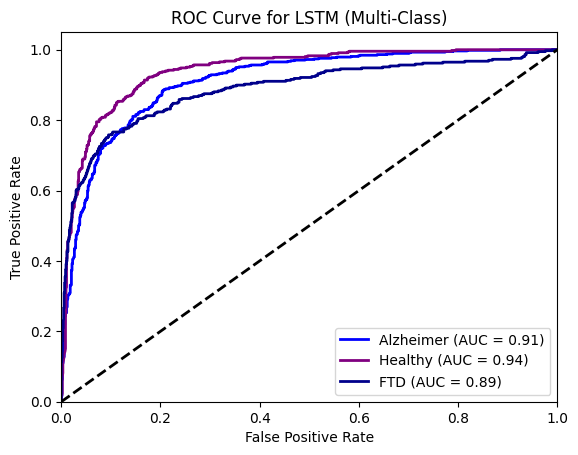

In [13]:
# Define colors for each class
colors = ['blue', 'purple', 'darkblue'] 

# Compute ROC curve and AUC for each class
y_test_onehot = torch.nn.functional.one_hot(y_test_cpu, num_classes=3).numpy()
y_pred_prob_array = torch.tensor(y_pred_prob).cpu().numpy()

plt.figure()
for i, class_name in enumerate(target_names):
    fpr, tpr, _ = roc_curve(y_test_onehot[:, i], y_pred_prob_array[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=colors[i], lw=2, label=f'{class_name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for LSTM (Multi-Class)')
plt.legend(loc="lower right")
plt.show()

Confusion Matrix:
[[462  73  41]
 [ 46 396  22]
 [ 74  44 250]]


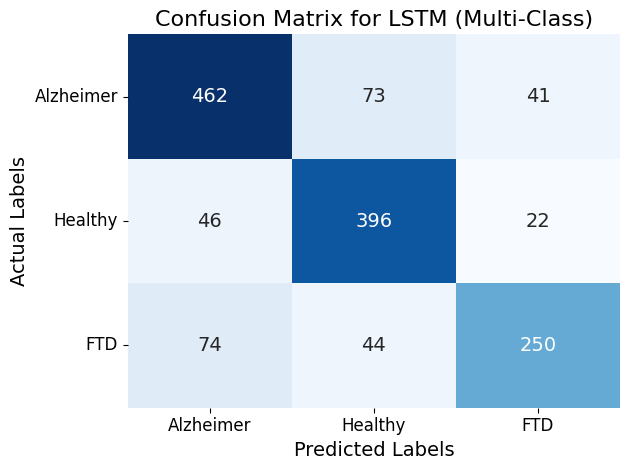

In [14]:
# Compute confusion matrix
conf_matrix = confusion_matrix(y_test_cpu, y_pred_cpu)

# Plot confusion matrix
plt.figure()
sns.heatmap(conf_matrix, cmap='Blues', annot=True, fmt='d', annot_kws={"size": 14}, cbar=False)
plt.xlabel('Predicted Labels', fontsize=14)
plt.ylabel('Actual Labels', fontsize=14)
plt.title('Confusion Matrix for LSTM (Multi-Class)', fontsize=16)
plt.xticks(ticks=[0.5, 1.5, 2.5], labels=target_names, fontsize=12)
plt.yticks(ticks=[0.5, 1.5, 2.5], labels=target_names, fontsize=12, rotation=0)
plt.tight_layout()

# Display the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)
plt.show()